# Self-Organizing Map applied to Time Series Exploratory Data Analysis

Frederico Furst Bittencourt

GPU-related code for Tensorflow inspired by https://github.com/lyes-khacef/GPU-SOM

Now mixing it up with data from a notebook in the ChaosDoc folder

# Preparatorily execute pls

## 1. Prep

#### GPUtil

In [1]:
!pip install GPUtil

##### From imports.py

In [2]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
import timeit

# import packages
import os, humanize, psutil # , sys, humanize, psutil, GPUtil
import GPUtil

# diable gpu
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"

# disable tensorflow logs
"""
0 = all messages are logged (default behavior)
1 = INFO messages are not printed
2 = INFO and WARNING messages are not printed
3 = INFO, WARNING, and ERROR messages are not printed
"""
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# import tensorflow
import tensorflow as tf
print("Tensorflow version = ", tf.__version__)
if tf.executing_eagerly():
    print("Eager execution!")
#tf.debugging.set_log_device_placement(True)

Tensorflow version =  2.16.1
Eager execution!


#### From gpu_check.py

Check for GPUs...

In [3]:
# imports
#from imports import *

# define function
def gpu_report():
    print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))
    GPUs = GPUtil.getGPUs()
    print(GPUs)
    for i, gpu in enumerate(GPUs):
        print('GPU {:d} ... Mem Free: {:.0f}MB / {:.0f}MB | Utilization {:3.0f}%'.format(i, gpu.memoryFree, gpu.memoryTotal, gpu.memoryUtil*100))

# GPU memory check
gpu_report()

CPU RAM Free: 1.2 GB
GPU 0 ... Mem Free: 4021MB / 4096MB | Utilization   2%


#### 2. Uploading file

In [4]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [5]:
os.chdir("D:\\Google Drive\\Mobmed\\")

In [6]:
# !ls

In [7]:
import pandas as pd

In [8]:
df1 = pd.read_fwf('e_composite_im7_8552_OHT_b-OHT-Hard-J3-ExpRed_S11.csv',
    header=[1,2],
    skip_blank_lines=True)

##### Get Column names For further vizes...

In [9]:
npdf1 = np.array(df1[:400],dtype=float).transpose()

In [10]:
npdf1.shape

(8301, 400)

## 3. Boilerplate

## Models

#### KSOM_3D

In [11]:
class KSOM_3D():
    def __init__(self, m, n, o, dim):
        self.m = m
        self.n = n
        self.o = o
        self.dim = dim
        self.map_wgt =  tf.Variable(
                            tf.random.uniform(
                                shape = [m*n*o, dim],
                                minval = 0.0,
                                maxval = 1.0,
                                dtype = tf.float32,
                                seed = 23
                            )
                        )
        self.map_loc =  tf.constant(
                            np.array(
                                list(self.neuron_locs(m, n, o))
                            )
                        )

    def neuron_locs(self, m, n, o):
        # nested iterations over both dimensions to yield one by one the 2-d locations of the individual neurons in the SOM
        for i in range(m):
            for j in range(n):
                for k in range(o):
                    yield np.array([i,j,k], dtype=np.float32)

    def compute_winner(self, sample):
            self.sample = sample

            # compute the squared euclidean distance between the input and the neurons
            self.squared_distance = tf.reduce_sum(
                                        tf.square(
                                            tf.subtract(
                                                self.map_wgt, # [m*n*o, dim]
                                                tf.expand_dims(
                                                    self.sample, # [dim] -> [1, dim]
                                                    axis=0
                                                )
                                            )
                                        ),
                                        axis=1
                                    )

            # find the bmu's index
            self.bmu_idx =  tf.argmin(
                                    input=self.squared_distance,
                                    axis=0
                                )

            # extract the bmu's 2-d location
            self.bmu_loc =  tf.gather(
                                self.map_loc,
                                self.bmu_idx
                            )

    def update_network(self, epsilon, eta):
        # compute the squared manhattan distance between the bmu and the neurons
        self.bmu_distance_squares = tf.reduce_sum(
                                        tf.square(
                                            tf.subtract(
                                                self.map_loc, # [m*n*o, 2]
                                                tf.expand_dims(
                                                    self.bmu_loc, # [2] -> [1, 2]
                                                    axis=0
                                                )
                                            )
                                        ),
                                        axis=1
                                    )

        # compute the neighborhood function
        self.neighbourhood_func = tf.exp(
                                      tf.negative(
                                          tf.math.divide(
                                              self.bmu_distance_squares,
                                              tf.multiply(
                                                  tf.square(
                                                      eta,
                                                  ),
                                                  2.0
                                              )
                                          )
                                      )
                                  )

        # compute the overall learning of each neuron
        self.learning = tf.multiply(
                            self.neighbourhood_func,
                            epsilon
                        )

        # compute the difference between the neurons weights and the input
        self.delta_wgt =  tf.subtract(
                              tf.expand_dims(
                                  self.sample, # [dim] -> [1, dim]
                                  axis=0
                              ),
                              self.map_wgt, # [m*n*o, dim]
                          )

        # compute the weights update according to the learning and delta_wgt and update the weights
        tf.compat.v1.assign_add(
            self.map_wgt,
            tf.multiply(
                tf.expand_dims(
                    self.learning, # [m*n*o] -> [m*n*o, 1]
                    axis=-1
                ),
                self.delta_wgt # [m*n*o, dim]
            )
        )

    def get_weights(self):
        return self.map_wgt

    @tf.function
    def train(self, nbr_epochs, epsilon_i, epsilon_f, eta_i, eta_f, x_train, x_label, index_label, x_test, index_test):
        with tf.device('/device:gpu:0'):
            for epoch in tf.range(nbr_epochs):
                tf.print("---------- Epoch", epoch + 1, "----------")

                # update the learning rate epsilon
                epsilon_t =  tf.multiply(
                                    epsilon_i,
                                    tf.pow(
                                        tf.math.divide(
                                            epsilon_f,
                                            epsilon_i
                                        ),
                                        tf.cast(
                                            tf.math.divide(
                                                epoch,
                                                nbr_epochs - 1
                                            ),
                                            dtype=tf.float32
                                        )
                                    )
                                )

                # update the gaussian neighborhood witdh eta
                eta_t =  tf.multiply(
                                  eta_i,
                                  tf.pow(
                                      tf.math.divide(
                                          eta_f,
                                          eta_i
                                      ),
                                      tf.cast(
                                          tf.math.divide(
                                              epoch,
                                              nbr_epochs - 1
                                          ),
                                          dtype=tf.float32
                                      )
                                  )
                              )

                # shuffle the training dataset
                tf.random.shuffle(x_train)

                # bmu computing and network update for each sample
                for x_trn in x_train:
                    sample = tf.cast(x_trn, dtype=tf.float32)
                    self.compute_winner(sample)
                    self.update_network(epsilon_t, eta_t)

#### KSOM

In [12]:
# imports
#from imports import *

class KSOM():
    def __init__(self, m, n, dim):
        self.m = m
        self.n = n
        self.dim = dim
        self.map_wgt =  tf.Variable(
                            tf.random.uniform(
                                shape = [m*n, dim],
                                minval = 0.0,
                                maxval = 1.0,
                                dtype = tf.float32,
                                seed = 23
                            )
                        )
        self.map_loc =  tf.constant(
                            np.array(
                                list(self.neuron_locs(m, n))
                            )
                        )

    def neuron_locs(self, m, n):
        # nested iterations over both dimensions to yield one by one the 2-d locations of the individual neurons in the SOM
        for i in range(m):
            for j in range(n):
                yield np.array([i,j], dtype=np.float32)

    def compute_winner(self, sample):
            self.sample = sample

            # compute the squared euclidean distance between the input and the neurons
            self.squared_distance = tf.reduce_sum(
                                        tf.square(
                                            tf.subtract(
                                                self.map_wgt, # [m*n, dim]
                                                tf.expand_dims(
                                                    self.sample, # [dim] -> [1, dim]
                                                    axis=0
                                                )
                                            )
                                        ),
                                        axis=1
                                    )

            # find the bmu's index
            self.bmu_idx =  tf.argmin(
                                    input=self.squared_distance,
                                    axis=0
                                )

            # extract the bmu's 2-d location
            self.bmu_loc =  tf.gather(
                                self.map_loc,
                                self.bmu_idx
                            )

    def update_network(self, epsilon, eta):
        # compute the squared manhattan distance between the bmu and the neurons
        self.bmu_distance_squares = tf.reduce_sum(
                                        tf.square(
                                            tf.subtract(
                                                self.map_loc, # [m*n, 2]
                                                tf.expand_dims(
                                                    self.bmu_loc, # [2] -> [1, 2]
                                                    axis=0
                                                )
                                            )
                                        ),
                                        axis=1
                                    )

        # compute the neighborhood function
        self.neighbourhood_func = tf.exp(
                                      tf.negative(
                                          tf.math.divide(
                                              self.bmu_distance_squares,
                                              tf.multiply(
                                                  tf.square(
                                                      eta,
                                                  ),
                                                  2.0
                                              )
                                          )
                                      )
                                  )

        # compute the overall learning of each neuron
        self.learning = tf.multiply(
                            self.neighbourhood_func,
                            epsilon
                        )

        # compute the difference between the neurons weights and the input
        self.delta_wgt =  tf.subtract(
                              tf.expand_dims(
                                  self.sample, # [dim] -> [1, dim]
                                  axis=0
                              ),
                              self.map_wgt, # [m*n, dim]
                          )

        # compute the weights update according to the learning and delta_wgt and update the weights
        tf.compat.v1.assign_add(
            self.map_wgt,
            tf.multiply(
                tf.expand_dims(
                    self.learning, # [m*n] -> [m*n, 1]
                    axis=-1
                ),
                self.delta_wgt # [m*n, dim]
            )
        )

    def get_weights(self):
        return self.map_wgt

    @tf.function
    def train(self, nbr_epochs, epsilon_i, epsilon_f, eta_i, eta_f, x_train, x_label, index_label, x_test, index_test):
        with tf.device('/device:gpu:0'):
            for epoch in tf.range(nbr_epochs):
                tf.print("---------- Epoch", epoch + 1, "----------")

                # update the learning rate epsilon
                epsilon_t =  tf.multiply(
                                    epsilon_i,
                                    tf.pow(
                                        tf.math.divide(
                                            epsilon_f,
                                            epsilon_i
                                        ),
                                        tf.cast(
                                            tf.math.divide(
                                                epoch,
                                                nbr_epochs - 1
                                            ),
                                            dtype=tf.float32
                                        )
                                    )
                                )

                # update the gaussian neighborhood witdh eta
                eta_t =  tf.multiply(
                                  eta_i,
                                  tf.pow(
                                      tf.math.divide(
                                          eta_f,
                                          eta_i
                                      ),
                                      tf.cast(
                                          tf.math.divide(
                                              epoch,
                                              nbr_epochs - 1
                                          ),
                                          dtype=tf.float32
                                      )
                                  )
                              )

                # shuffle the training dataset
                tf.random.shuffle(x_train)

                # bmu computing and network update for each sample
                for x_trn in x_train:
                    sample = tf.cast(x_trn, dtype=tf.float32)
                    self.compute_winner(sample)
                    self.update_network(epsilon_t, eta_t)

# Visualizations

Run 2D som

In [13]:
# ####################################################################################################
# GPU-based Self-Organizing-Map by Lyes Khacef.
# Reference: L. Khacef, V. Gripon, and B. Miramond, “GPU-based self-organizing-maps
# for post-labeled few-shot unsupervised learning”, in International Conference On
# Neural Information Processing (ICONIP), 2020.
# ####################################################################################################

# hyper-parameters
x_train = npdf1
x_label, index_label, x_test, index_test = False, False, False, False
input_dim = 400 #784
map_wth = 8
map_hgt = 8
class_nbr = 10
nbr_epochs = 20
eps_i_list = [1.0]
eps_f_list = [0.01]
eta_i_list = [10.0]
eta_f_list = [0.01]
sigma_kernel = 1.0

# GPU name
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    pass
    # raise SystemError("GPU device not found!")
print('Found GPU at: {}'.format(device_name))



##
## how the hell
##
# false run_som(false, false, false, eta_f):
def run_som(eps_i, eps_f, eta_i, eta_f):
    print("\nHyper-parameters:   # eps_i = %f   # eps_f = %f   # eta_i = %f   # eta_f = %f" % (eps_i, eps_f, eta_i, eta_f))
    # train the network
    som = KSOM(map_wth, map_hgt, input_dim)
    start_time = timeit.default_timer()
    som.train(nbr_epochs, eps_i, eps_f, eta_i, eta_f, x_train, x_label, index_label, x_test, index_test)
    end_time = timeit.default_timer()
    print("\nSOM training time = ", end_time - start_time)
    weights = som.get_weights().numpy()

    # save the weights
    #np.save("weights/som_weights.npy", weights)

    ##
    ## Now you no label
    ##
    # label the network
    #neuron_label = labeling(label_data, class_nbr, weights, x_label, index_label, sigma_kernel)
    neuron_label = False

    ##
    ## Now you no accuracy
    # test the network
    #accuracy = test(class_nbr, weights, x_test, index_test, neuron_label, sigma_kernel)
    accuracy = False

    return weights, accuracy, som

# hyper-parameters grid search
hyper_param_list, accuracy_list = [], []
for eps_i in eps_i_list:
    for eps_f in eps_f_list:
        for eta_i in eta_i_list:
            for eta_f in eta_f_list:
                hyper_param_list.append([eps_i, eps_f, eta_i, eta_f])
                weights, accuracy, som = run_som(eps_i, eps_f, eta_i, eta_f)
                accuracy_list.append(accuracy)


Found GPU at: 

Hyper-parameters:   # eps_i = 1.000000   # eps_f = 0.010000   # eta_i = 10.000000   # eta_f = 0.010000

---------- Epoch 1 ----------
---------- Epoch 2 ----------
---------- Epoch 3 ----------
---------- Epoch 4 ----------
---------- Epoch 5 ----------
---------- Epoch 6 ----------
---------- Epoch 7 ----------
---------- Epoch 8 ----------
---------- Epoch 9 ----------
---------- Epoch 10 ----------
---------- Epoch 11 ----------
---------- Epoch 12 ----------
---------- Epoch 13 ----------
---------- Epoch 14 ----------
---------- Epoch 15 ----------
---------- Epoch 16 ----------
---------- Epoch 17 ----------
---------- Epoch 18 ----------
---------- Epoch 19 ----------
---------- Epoch 20 ----------

SOM training time =  24.85827260000042


In [14]:
lw = [ 0 for i in range(map_wth*map_hgt) ]

def distance(x,y):
    assert len(x)==len(y)
    n = len(x)
    result = 0
    for i in range(n):
        result += (x[i] - y[i])**2
    return result

for xt in x_train:
    # print(np.reshape(xt,(1,-1)))
    # som.compute_winner(np.reshape(xt,(1,-1)))
    distancias = [ distance(xt, weights[k]) for k in range(map_wth*map_hgt) ]
    minimo = min(distancias)
    indice = distancias.index(minimo)
    # print('indice',indice)
    lw[indice] += 1

In [15]:
lwnp = np.array(lw)/max(lw)*2+0.5

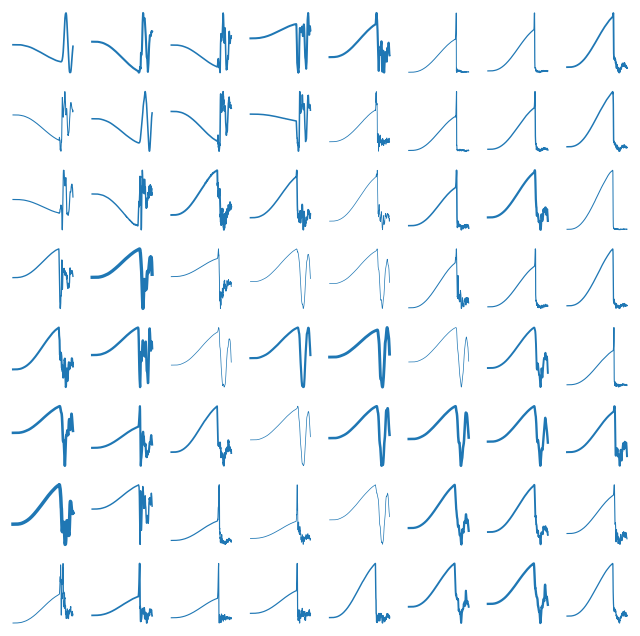

In [16]:
# display neurons weights as mnist digits
som_grid = plt.figure(figsize=(8, 8)) # width, height in inches
for n in range(map_wth*map_hgt):
    ##
    ## Must make this into time series plot. Shouldnt be the thing
    ##
    #image = weights[n].reshape([28,28]) # x_train[num] is the 784 normalized pixel values
    sub = som_grid.add_subplot(map_wth, map_hgt, n + 1)
    sub.set_axis_off()
    clr = sub.plot(weights[n], linewidth=lwnp[n])
plt.savefig("som_weights.png")
plt.show()

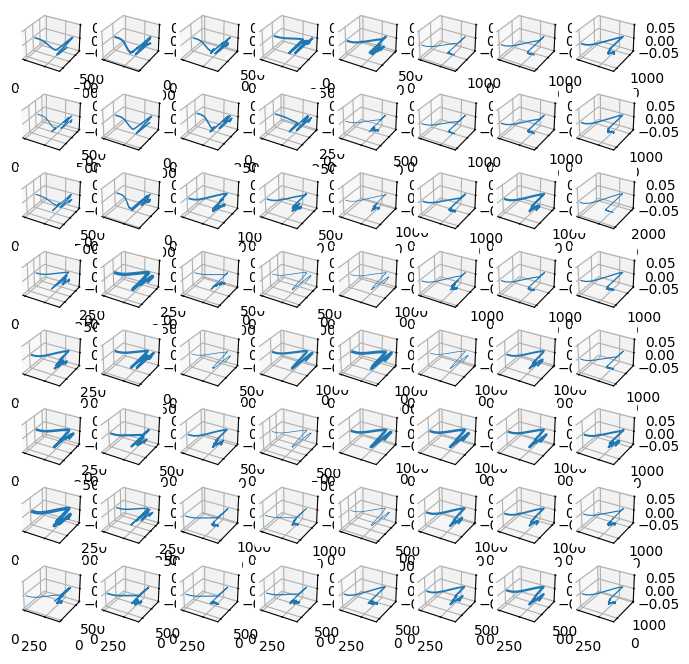

In [17]:
# display neurons weights as mnist digits
som_grid = plt.figure(figsize=(8, 8)) # width, height in inches
for n in range(map_wth*map_hgt):
    ##
    ## Must make this into time series plot. Shouldnt be the thing
    ##
    #image = weights[n].reshape([28,28]) # x_train[num] is the 784 normalized pixel values
    sub = som_grid.add_subplot(map_wth, map_hgt, n + 1, projection='3d')
    # sub.set_axis_off()
    clr = sub.plot(range(len(weights[n])), weights[n], 0, linewidth=lwnp[n])
plt.savefig("som_weights.png")
plt.show()

### run 3D som

Run 3D som

In [26]:
# ####################################################################################################
# GPU-based Self-Organizing-Map by Lyes Khacef.
# Reference: L. Khacef, V. Gripon, and B. Miramond, “GPU-based self-organizing-maps
# for post-labeled few-shot unsupervised learning”, in International Conference On
# Neural Information Processing (ICONIP), 2020.
# ####################################################################################################

# hyper-parameters
x_train = npdf1
x_label, index_label, x_test, index_test = False, False, False, False
input_dim = 400 #784
map_wth = 4
map_hgt = 3
map_dpt = 50
class_nbr = 10
nbr_epochs = 20
eps_i_list = [1.0]
eps_f_list = [0.01]
eta_i_list = [10.0]
eta_f_list = [0.01]
sigma_kernel = 1.0

# GPU name
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    pass
    # raise SystemError("GPU device not found!")
print('Found GPU at: {}'.format(device_name))



##
## how the hell
##
# false run_som(false, false, false, eta_f):
def run_som(eps_i, eps_f, eta_i, eta_f):
    print("\nHyper-parameters:   # eps_i = %f   # eps_f = %f   # eta_i = %f   # eta_f = %f" % (eps_i, eps_f, eta_i, eta_f))
    # train the network
    som = KSOM_3D(map_wth, map_hgt, map_dpt, input_dim)
    start_time = timeit.default_timer()
    som.train(nbr_epochs, eps_i, eps_f, eta_i, eta_f, x_train, x_label, index_label, x_test, index_test)
    end_time = timeit.default_timer()
    print("\nSOM training time = ", end_time - start_time)
    weights = som.get_weights().numpy()

    # save the weights
    #np.save("weights/som_weights.npy", weights)

    ##
    ## Now you no label
    ##
    # label the network
    #neuron_label = labeling(label_data, class_nbr, weights, x_label, index_label, sigma_kernel)
    neuron_label = False

    ##
    ## Now you no accuracy
    # test the network
    #accuracy = test(class_nbr, weights, x_test, index_test, neuron_label, sigma_kernel)
    accuracy = False

    return weights, accuracy, som

# hyper-parameters grid search
hyper_param_list, accuracy_list = [], []
for eps_i in eps_i_list:
    for eps_f in eps_f_list:
        for eta_i in eta_i_list:
            for eta_f in eta_f_list:
                hyper_param_list.append([eps_i, eps_f, eta_i, eta_f])
                weights, accuracy, som = run_som(eps_i, eps_f, eta_i, eta_f)
                accuracy_list.append(accuracy)


Found GPU at: 

Hyper-parameters:   # eps_i = 1.000000   # eps_f = 0.010000   # eta_i = 10.000000   # eta_f = 0.010000
---------- Epoch 1 ----------
---------- Epoch 2 ----------
---------- Epoch 3 ----------
---------- Epoch 4 ----------
---------- Epoch 5 ----------
---------- Epoch 6 ----------
---------- Epoch 7 ----------
---------- Epoch 8 ----------
---------- Epoch 9 ----------
---------- Epoch 10 ----------
---------- Epoch 11 ----------
---------- Epoch 12 ----------
---------- Epoch 13 ----------
---------- Epoch 14 ----------
---------- Epoch 15 ----------
---------- Epoch 16 ----------
---------- Epoch 17 ----------
---------- Epoch 18 ----------
---------- Epoch 19 ----------
---------- Epoch 20 ----------

SOM training time =  97.20928430000004


#### Viz for KSOM_3D

TF gpu-possibly version

In [20]:
 with tf.device('/device:gpu:0'):
            for epoch in tf.range(nbr_epochs):
                tf.print("---------- Epoch", epoch + 1, "----------")

                # update the learning rate epsilon
                epsilon_t =  tf.multiply(
                                    epsilon_i,
                                    tf.pow(
                                        tf.math.divide(
                                            epsilon_f,
                                            epsilon_i
                                        ),
                                        tf.cast(
                                            tf.math.divide(
                                                epoch,
                                                nbr_epochs - 1
                                            ),
                                            dtype=tf.float32
                                        )
                                    )
                                )
    lw = [ 0 for i in range(map_wth*map_hgt*map_dpt) ]
    
    def distance(x,y):
        assert len(x)==len(y)
        n = len(x)
        result = 0
        for i in tf.range(n):
            tf.print("Very n: "+str(n))
            result += tf.pow((x[i], y[i]), 2)
        return result
    
    for xt in x_train:
        # print(np.reshape(xt,(1,-1)))
        # som.compute_winner(np.reshape(xt,(1,-1)))
        distancias = [ distance(xt, weights[k]) for k in range(map_wth*map_hgt*map_dpt) ]
        minimo = min(distancias)
        indice = distancias.index(minimo)
        # print('indice',indice)
        lw[indice] += 1

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 22)

Regular version

In [ ]:
lw = [ 0 for i in range(map_wth*map_hgt*map_dpt) ]

def distance(x,y):
    assert len(x)==len(y)
    n = len(x)
    result = 0
    for i in range(n):
        result += (x[i] - y[i])**2
    return result

for xt in x_train:
    # print(np.reshape(xt,(1,-1)))
    # som.compute_winner(np.reshape(xt,(1,-1)))
    distancias = [ distance(xt, weights[k]) for k in range(map_wth*map_hgt*map_dpt) ]
    minimo = min(distancias)
    indice = distancias.index(minimo)
    # print('indice',indice)
    lw[indice] += 1

In [ ]:
lwnp = np.array(lw)/max(lw)*1.5+0.0

In [ ]:
weights.shape

In [ ]:
# display neurons weights as mnist digits
som_grid = plt.figure(figsize=(8, 8)) # width, height in inches
for n in range(map_wth*map_hgt):
    ##
    ## Must make this into time series plot. Shouldnt be the thing
    ##
    #image = weights[n].reshape([28,28]) # x_train[num] is the 784 normalized pixel values
    sub = som_grid.add_subplot(map_wth, map_hgt, n + 1, projection='3d')
    # sub.set_axis_off()
    # clr = sub.plot(weights[n], linewidth=lwnp[n])
    # imshow(image, cmap = plt.get_cmap("jet"), interpolation = "nearest")
    for m in range(map_dpt):
        sub.plot(range(len(weights[n+m])),weights[n+m], m, linewidth=lwnp[n+m])
        sub.set_xlabel('t (s)')
        sub.set_ylabel('$\sigma_{11} (MPa)$')
        # sub.set_zlabel('z')
plt.savefig("som_weights.png")
plt.show()

In [ ]:
# display neurons weights as mnist digits
som_grid = plt.figure(figsize=(8, 8)) # width, height in inches
for n in range(map_wth*map_hgt):
    ##
    ## Must make this into time series plot. Shouldnt be the thing
    ##
    #image = weights[n].reshape([28,28]) # x_train[num] is the 784 normalized pixel values
    sub = som_grid.add_subplot(map_wth, map_hgt, n + 1)
    sub.set_axis_off()
    # clr = sub.plot(weights[n], linewidth=lwnp[n])
    # imshow(image, cmap = plt.get_cmap("jet"), interpolation = "nearest")
    for m in range(map_dpt):
        sub.plot(weights[n+m], linewidth=lwnp[n+m])
plt.savefig("som_weights.png")
plt.show()